In [1]:
#Set up the environment and upload the data
from sklearn.preprocessing import StandardScaler
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep 
from tqdm.notebook import tqdm
import os
sns.set()

In [2]:
#Dataset that should go with Alzheimer label
very_mild = glob(r'C:\Users\Amzu_phonography\Downloads\Alz_mri_dataset\Dataset\Very_Mild_Demented\*')
mild = glob(r'C:\Users\Amzu_phonography\Downloads\Alz_mri_dataset\Dataset\Mild_Demented\*')
moderate = glob(r'C:\Users\Amzu_phonography\Downloads\Alz_mri_dataset\Dataset\Moderate_Demented\*')

#Dataset without Alzheimer
non = glob(r'C:\Users\Amzu_phonography\Downloads\Alz_mri_dataset\Dataset\Non_Demented\*')

C:\Users\Amzu_phonography\Downloads\Alz_mri_dataset\Dataset\Non_Demented\non_10.jpg
One of the data in Non Alzheimer Folder
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

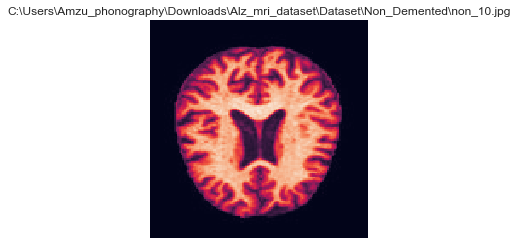

In [3]:
print(non[1])
def view_image(directory):
    img = mpimg.imread(directory)
    plt.imshow(img)
    plt.title(directory)
    plt.axis('off')
    print(f'Image shape:{img.shape}')
    return img

print('One of the data in Non Alzheimer Folder')
view_image(non[1])

Alzheimer Patient's Brain
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

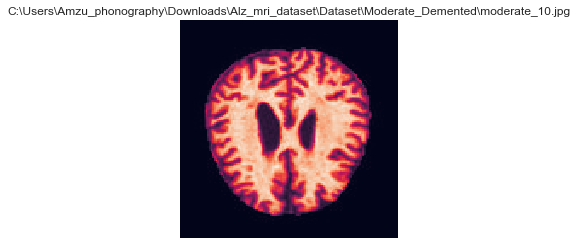

In [4]:
print('Alzheimer Patient\'s Brain')
view_image(moderate[1])

Number of components explaining 80% variance: 174
[[-14.4199889    2.77385778  17.37749418 ...  -0.13949655   1.00653566
    0.89050335]
 [-16.96933988   3.4241097    6.65184773 ...  -1.71247485  -0.44951808
    0.3800723 ]
 [ 22.43206308 -19.01960075   0.60701848 ...  -0.74843728  -0.71534534
   -0.65085517]
 ...
 [-17.65214974   4.29873057   1.21460338 ...  -0.73403895  -1.57234311
    1.20217632]
 [-10.77570065  18.13876676   6.30439208 ...   0.04589243   0.47072726
   -1.71584883]
 [-16.92585331  -2.25633301  -2.05813782 ...   0.58296544   1.11049564
    0.36579055]]


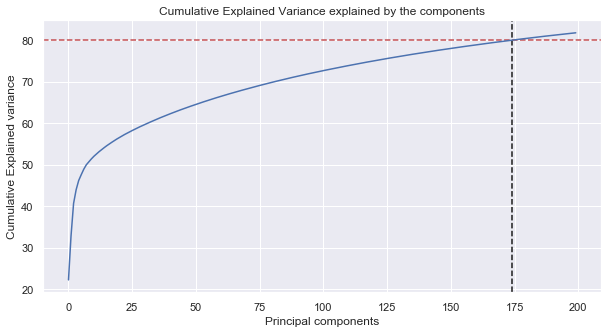

In [5]:
def extract_feature(dir_path):
    img = mpimg.imread(dir_path)
    img = img / 255.0  # normalize pixel values
    img = resize(img, (128, 128, 3))  # convert all images to (128x128x3)
    img = np.reshape(img, (128, 384))
    return img

non_ALZ = [extract_feature(filename) for filename in non]
vmild_ALZ = [extract_feature(filename) for filename in very_mild]
mild_ALZ = [extract_feature(filename) for filename in mild]
moderate_ALZ = [extract_feature(filename) for filename in moderate]
ALZ = vmild_ALZ + mild_ALZ + moderate_ALZ

#for PCA
all_data = np.concatenate((np.array(non_ALZ),np.array(ALZ)))
#print(all_data)
all_data = all_data.reshape(all_data.shape[0], np.product(all_data.shape[1:]))

scaler = StandardScaler()
scaler.fit(all_data)

#standardize data to 0 mean and unit variance
X = scaler.transform(all_data)

#split the data 
from sklearn.model_selection import train_test_split
y = [0] * len(non_ALZ) + [1] * len(ALZ)
X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size=0.2)

scala = preprocessing.StandardScaler()
#Compressing the images into two dimensions using PCA
pca = decomposition.PCA(200)
X_proj = pca.fit_transform(X_train)

#let's first see which principal component works better
#scree plot but cumulative
# Getting the cumulative variance 
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100 #100 is multiplied for percentage
 
# How many PCs explain 90% of the variance?
k = np.argmax(var_cumu>80)
print("Number of components explaining 80% variance: "+ str(k)) #I guess, I will have to use 160 axis
#print("\n")
 
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=80, color="r", linestyle="--")
ax = plt.plot(var_cumu)

print(X_proj)

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_train_LDA = lda.fit_transform(X_train, y_train)
X_test_LDA = lda.transform(X_test)
accuracy = lda.score(X_test, y_test)
print(accuracy*100, '% accuracy (testing data)' )
accuracy_train = lda.score(X_train, y_train)
print(accuracy_train*100, '% accuracy (training data)')

88.28125 % accuracy (testing data)
99.98046875 % accuracy (training data)


In [7]:
#List where arrays shall be stored
resized_image_array=[]
#List that will store the answer if an image is female (0) or male (1)
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) #the data is just black to white 

#Iterate over pictures and resize them to 256 by 256
def resizer(image_directory):
    for file in image_directory: #tried with os.listdir but could work with os.walk as well
        img = Image.open(file) #just putting image_directory or file does not work for google colab, interesting. 
        #preserve aspect ratio
        img = img.resize(new_size)
        array_temp = np.array(img)
        shape_new = width*height
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        if image_directory == non:
            resized_image_array_label.append(0)
        else:
            resized_image_array_label.append(1)

ALZ = very_mild + mild + moderate
resizer(non)
resizer(ALZ)

In [8]:
print(len(non))
print(len(ALZ)) #data are well transformed. Let's conduct SVM
print(len(resized_image_array))
print(resized_image_array[1])

#split the data to test and training
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)

3200
3200
6400
[0 0 0 ... 0 0 0]


In [9]:
#train SVM model
#from sklearn import svm
clf = svm.SVC(kernel = 'linear')
clf.fit(train_x, train_y)
#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred)) #The training seems to be done with high accuracy on training data.

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred)) #Having high training data accuracy might mean that it is having some overfitting

Accuracy :  1.0
Precision :  1.0
Recall :  1.0
f1 :  1.0
Confusion matrix : [[2570    0]
 [   0 2550]]
Accuracy :  0.98359375
Precision :  0.9891135303265941
Recall :  0.9784615384615385
f1 :  0.9837587006960558
Confusion matrix : [[623   7]
 [ 14 636]]


In [10]:
#Train a SVM using polynomial kernel with degree of 2
clf = svm.SVC(kernel = 'poly', degree = 2)
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

Accuracy :  0.892578125
Precision :  0.8881987577639752
Recall :  0.8972549019607843
f1 :  0.8927038626609441
Confusion matrix : [[2282  288]
 [ 262 2288]]
Accuracy :  0.85703125
Precision :  0.8428781204111601
Recall :  0.8830769230769231
f1 :  0.8625093914350113
Confusion matrix : [[523 107]
 [ 76 574]]


In [11]:
#Train a SVM using RBF kernel
clf = svm.SVC(kernel = 'rbf')
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('Precision : ', metrics.precision_score(y_true, y_pred))
print('Recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred)) 
print('Confusion matrix :', metrics.confusion_matrix(y_true, y_pred))

Accuracy :  0.8654296875
Precision :  0.849943587814968
Recall :  0.8862745098039215
f1 :  0.8677289306968708
Confusion matrix : [[2171  399]
 [ 290 2260]]
Accuracy :  0.82890625
Precision :  0.8039492242595204
Recall :  0.8769230769230769
f1 :  0.8388520971302428
Confusion matrix : [[491 139]
 [ 80 570]]


In [12]:
#This code cell is a revised version of Code snippet for pre-processing mnist data:https://github.com/keras-team/keras/issues/11208
#The above code is revised for this project's purpose. 
import cv2
dim = (128, 128) #original shape of the image

def extract_feature(dir_path):
    img = mpimg.imread(dir_path)
    img = img / 255.0  # normalize pixel values
    img = resize(img, (128, 128, 3))  # convert all images to (128x128x3)
    img = np.reshape(img, (128, 384))
    return img

non_ALZ = [extract_feature(filename) for filename in non]
vmild_ALZ = [extract_feature(filename) for filename in very_mild]
mild_ALZ = [extract_feature(filename) for filename in mild]
moderate_ALZ = [extract_feature(filename) for filename in moderate]
ALZ = vmild_ALZ + mild_ALZ + moderate_ALZ

#for PCA
all_data = np.concatenate((np.array(non_ALZ),np.array(ALZ)))
#print(all_data)
all_data = all_data.reshape(all_data.shape[0], np.product(all_data.shape[1:]))

scaler = StandardScaler()
scaler.fit(all_data)

#standardize data to 0 mean and unit variance
X = scaler.transform(all_data)

#split the data 
from sklearn.model_selection import train_test_split
y = [0] * len(non_ALZ) + [1] * len(ALZ)
X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size=0.2)

#convert grayscale to 128x128 rgb channels
def to_rgb(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb

rgb_list = []
#convert X_train data to 128x128 rgb values
for i in range(len(X_train)):
    rgb = to_rgb(X_train[i])
    rgb_list.append(rgb)
    #print(rgb.shape)
    
rgb_arr = np.stack([rgb_list],axis=4)
rgb_arr_to_3d = np.squeeze(rgb_arr, axis=4)
print(rgb_arr_to_3d.shape)

(5120, 128, 128, 3)


In [13]:
rgb_list_test = []
#convert X_test data to 128x128 rgb values
for i in range(len(X_test)):
    rgb = to_rgb(X_test[i])
    rgb_list_test.append(rgb)
    #print(rgb.shape)
    
rgb_arr_test = np.stack([rgb_list_test],axis=4)
rgb_arr_to_3d_test = np.squeeze(rgb_arr_test, axis=4)
print(rgb_arr_to_3d_test.shape)

(1280, 128, 128, 3)


In [14]:
#set up the environment
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

vgg16 = VGG16(weights = 'imagenet', input_shape = (128, 128, 3), include_top = False)
vgg16.summary()

vgg16.trainable = False
final_model = Sequential()
final_model.add(vgg16)
final_model.add(Flatten(name='flatten'))
final_model.add(Dense(2,activation = 'softmax', name = 'predictions'))
final_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

final_model.fit(rgb_arr_to_3d, np.array(y_train).reshape(-1,1), batch_size = 7, epochs = 10, verbose = 1)
final_model.fit(rgb_arr_to_3d_test, np.array(y_test).reshape(-1,1), batch_size = 7, epochs = 10, verbose = 1)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [15]:
#List where arrays shall be stored
resized_image_array=[]
#List that will store the answer if an image is female (0) or male (1)
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) #the data is just black to white 

#Iterate over pictures and resize them to 256 by 256
def resizer(image_directory):
    for file in image_directory: #tried with os.listdir but could work with os.walk as well
        img = Image.open(file) #just putting image_directory or file does not work for google colab, interesting. 
        #preserve aspect ratio
        img = img.resize(new_size)
        array_temp = np.array(img)
        shape_new = width*height
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        if image_directory == non:
            resized_image_array_label.append(0)
        elif image_directory == very_mild:
            resized_image_array_label.append(1)
        elif image_directory == mild:
            resized_image_array_label.append(2)
        else:
            resized_image_array_label.append(3)

resizer(non)
resizer(very_mild)
resizer(mild)
resizer(moderate)

#split the data to test and training
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)

#train SVM model
#from sklearn import svm
clf = svm.SVC(kernel = 'linear')
clf.fit(train_x, train_y)
#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

Accuracy :  1.0
Accuracy :  0.9890625


In [16]:
#Train a SVM using polynomial kernel with degree of 2
clf = svm.SVC(kernel = 'poly', degree = 2)
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

Accuracy :  0.8759765625
Accuracy :  0.82109375


In [18]:
#Train a SVM using RBF kernel
clf = svm.SVC(kernel = 'rbf')
clf.fit(train_x, train_y)

#store predictions and ground truth
y_pred = clf.predict(train_x)
y_true = train_y

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(test_x)
y_true = test_y

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

Accuracy :  0.8126953125
Accuracy :  0.77421875


Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.
16719872/16705208 [==============================] - 59s 4us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012

[2.240657091140747, 0.5703125]

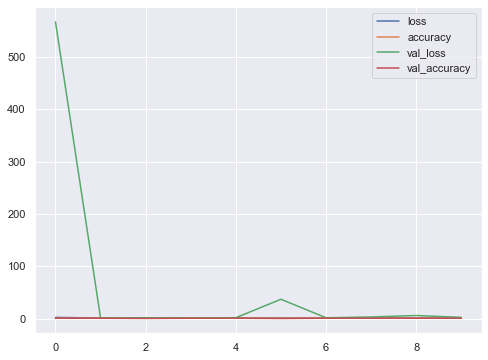

In [20]:
import tensorflow as tf
#syntax from https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
data = r'C:\Users\Amzu_phonography\Downloads\Alz_mri_dataset\Dataset'
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels = 'inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    color_mode='grayscale',
    image_size=(128,128),
    batch_size=32,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels = 'inferred',
    label_mode='categorical',
    validation_split= 0.2,
    subset="validation",
    seed=42,
    color_mode= 'grayscale',
    image_size = (128,128),
    batch_size=32,
)

#Model setup
EffNet = tf.keras.applications.EfficientNetB0(include_top = False)
EffNet.trainable = True
inputs = tf.keras.layers.Input(shape=((128,128) + (1,)), name = 'input_layer')
x = EffNet(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
Learning_Rate = 0.1
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = Learning_Rate), metrics=['accuracy'])
model.summary()

#Training the Model
graphs = model.fit(train_data, validation_data = test_data, epochs = 10, verbose = False)
pd.DataFrame(graphs.history).plot(figsize=(8,6))

#check the performance
model.evaluate(test_data)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________
40/40 [==============================] - 16s 400ms/step - loss: 1.0525 - accuracy: 0.7383


[1.052537202835083, 0.73828125]

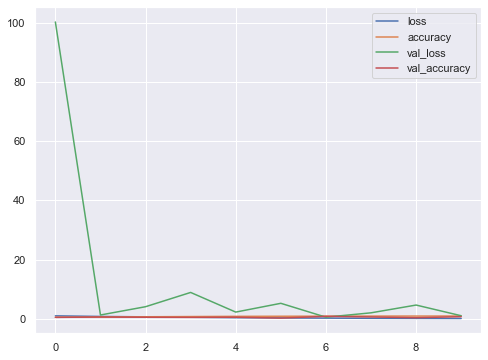

In [21]:
#Model Changing the learning rate
EffNet = tf.keras.applications.EfficientNetB0(include_top = False)
EffNet.trainable = True
inputs = tf.keras.layers.Input(shape=((128,128) + (1,)), name = 'input_layer')
x = EffNet(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
Learning_Rate = 0.01
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = Learning_Rate), metrics=['accuracy'])
model.summary()

#Training the Model
graphs = model.fit(train_data, validation_data = test_data, epochs = 10, verbose = False)
pd.DataFrame(graphs.history).plot(figsize=(8,6))

#check the performance
model.evaluate(test_data)

In [26]:
directory = r'C:\Users\Amzu_phonography\Downloads\Alz_mri_dataset\Dataset'
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________
40/40 [==============================] - 46s 1s/step - loss: 0.9915 - accuracy: 0.7367


[0.9915016293525696, 0.7367187738418579]

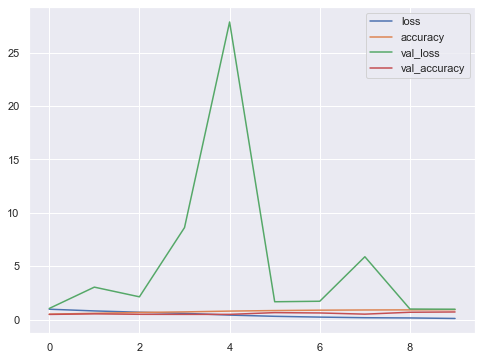

In [27]:
#Model setup
EffNet = tf.keras.applications.EfficientNetB0(include_top = False)
EffNet.trainable = True
inputs = tf.keras.layers.Input(shape=((224,224) + (1,)), name = 'input_layer')
x = EffNet(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
Learning_Rate = 0.01
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = Learning_Rate), metrics=['accuracy'])
model.summary()

#Training the Model
graphs = model.fit(training_dataset, validation_data = testing_dataset, epochs = 10, verbose = False)
pd.DataFrame(graphs.history).plot(figsize=(8,6))

#check the performance
model.evaluate(testing_dataset)